In [1]:
#Import
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
from matplotlib import pyplot as plt
import scipy

In [2]:
#Read in data
DF90 = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/CASA0007/national/1990.csv', index_col=0)
DF00 = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/CASA0007/national/2000.csv', index_col=0)

In [3]:
#Calculate
DF00['AUSRH'] = DF00['SRH'] / DF00['UP']
DF00['AUSARH'] = DF00['SARH'] / DF00['UP']
DF00['ASRH'] = DF00['SRH'] / DF00['TP']
DF00['ASARH'] = DF00['SARH'] / DF00['TP']
DF00['HIR'] = DF00['SPRH'] / DF00['DPI']
DF00['RA65'] = DF00['A65'] / DF00['TP']

In [4]:
#Def VIF
def drop_column_using_vif_(df, thresh=5):
    while True:
        df_with_const = add_constant(df)
        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()
        vif_df = vif_df.drop('const')
        if vif_df.VIF.max() > thresh:
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            break
    return df

In [5]:
#VIF
WILLING = DF00[['HIR','GDR','NPGR']]
WILLING_VIF = drop_column_using_vif_(WILLING)

In [6]:
#OLS
#OLS_y: AUSARH - SARH住宅销售面积 / UP城镇人口
#OLS_x: HIR - SPRH住宅销售价格 / DPI居民人均可支配收入, GDR - 人口抚养比, NPGR - 人口自然增长率
OLS_y = DF00['AUSARH'].apply(np.log)
OLS_x = DF00[['HIR','GDR','NPGR']]
olsresult = sm.OLS(endog = OLS_y, exog = sm.add_constant(OLS_x)).fit()
olsresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 AUSARH   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     69.08
Date:                Sun, 15 Jan 2023   Prob (F-statistic):           4.51e-10
Time:                        13:11:10   Log-Likelihood:                 12.165
No. Observations:                  22   AIC:                            -16.33
Df Residuals:                      18   BIC:                            -11.97
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5489      0.541      8.403      0.000       3.412       5.686
HIR           -4.1776      0.597     -6.994      0.000      -5.433      -2.923
GDR           -0.0573      0.014     -4.218      0.001      -0.086      -0.029
NPGR          -0.1251      0.029     -4.275      0.000      -0.187      -0.064
==============================================================================
Omnibus:                        0.449   Durbin-Watson:                   2.279
Prob(Omnibus):                  0.799   Jarque-Bera (JB):                0.446
Skew:                          -0.290   Prob(JB):                        0.800
Kurtosis:                       2.612   Cond. No.                         797.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

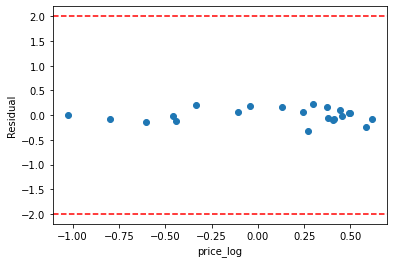

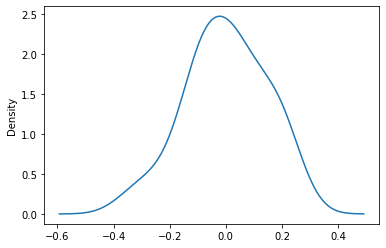

KstestResult(statistic=0.41281951709916664, pvalue=0.0006598243801234638)
NormaltestResult(statistic=0.44860328075460715, pvalue=0.7990740650106034)
(8.330620956639834, 0.015524894008744388, 3.859765628320949, 0.025964214791507758)


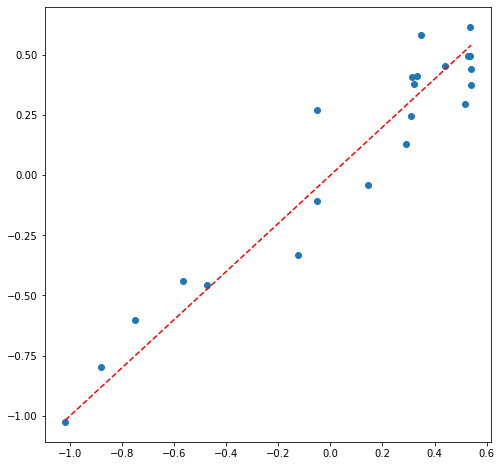

In [15]:
#残差检验
plt.scatter(olsresult.fittedvalues, olsresult.resid)
plt.xlabel('price_log')
plt.ylabel('Residual')
plt.axhline(y=2, color='r', linestyle='--')
plt.axhline(y=-2, color='r', linestyle='--') 
plt.show()

#残差正态性检验
plt.figure()
olsresult.resid.plot.density()
plt.show()
kstest = scipy.stats.kstest(olsresult.resid,cdf = "norm")
normaltest = scipy.stats.normaltest(olsresult.resid)
print(kstest)
print(normaltest)

#残差方差齐性检验
#第一个值为LM统计量；第二个值是统计量对应的概率p值；第三个值为F统计量，用于检验残差平方项与自变量之间是否独立，如果独立则表明残差方差齐性；第四个值则为F统计量的概率p值，同样大于0.05，则进一步表示残差项满足方差齐性的假设。
BP_test = statsmodels.stats.diagnostic.het_breuschpagan(exog_het = OLS_x, resid = olsresult.resid)
print(BP_test)

#回归拟合
fig, ax = plt.subplots(figsize=(8,8))
predict = olsresult.fittedvalues
pd.DataFrame({"Prediction":predict,"Real":OLS_y})
plt.scatter(x = OLS_y, y = predict) 
plt.plot([OLS_y.min(),OLS_y.max()],[OLS_y.min(),OLS_y.max()],color = "red", linestyle = "--")
plt.show()

In [8]:
#Province Data
AUSARH = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/CASA0007/province/AUSARH.csv',index_col=0).T
GDR = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/CASA0007/province/GDR.csv',index_col=0).T
HIR = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/CASA0007/province/HIR.csv',index_col=0).T
NPGR = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/CASA0007/province/NPGR.csv',index_col=0).T
SARH = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/CASA0007/province/SARH.csv',index_col=0).T
SPRH = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/CASA0007/province/SPRH.csv',index_col=0).T
UP = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/CASA0007/province/UP.csv',index_col=0).T

In [9]:
AUSARH['province'] = AUSARH.index
GDR['province'] = GDR.index
HIR['province'] = HIR.index
NPGR['province'] = NPGR.index
SARH['province'] = SARH.index
SPRH['province'] = SPRH.index
UP['province'] = UP.index

melted_AUSARH = pd.melt(AUSARH, id_vars=['province'], value_vars=[2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021])
melted_GDR = pd.melt(GDR, id_vars=['province'], value_vars=[2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021])
melted_HIR = pd.melt(HIR, id_vars=['province'], value_vars=[2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021])
melted_NPGR = pd.melt(NPGR, id_vars=['province'], value_vars=[2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021])
melted_SARH = pd.melt(SARH, id_vars=['province'], value_vars=[2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021])
melted_SPRH = pd.melt(SPRH, id_vars=['province'], value_vars=[2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021])
melted_UP = pd.melt(UP, id_vars=['province'], value_vars=[2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021])

national = pd.DataFrame({'province': melted_AUSARH['province'], 'year': melted_AUSARH['Year'], 'AUSARH': melted_AUSARH['value'], 'GDR': melted_GDR['value'], 'HIR': melted_HIR['value'], 'NPGR': melted_NPGR['value'], 'SARH': melted_SARH['value'], 'SPRH': melted_SPRH['value'], 'UP': melted_UP['value']})
national['AUSARH_log'] = np.log(national['AUSARH'])

In [10]:
'''
def extract(i):
    AUSARHi = AUSARH[i]
    GDRi = GDR[i]
    HIRi = HIR[i]
    NPGRi = NPGR[i]
    SARHi = SARH[i]
    SPRHi = SPRH[i]
    UPi = UP[i]
    
    SETi = pd.DataFrame({'AUSARH':AUSARHi, 'GDR':GDRi, 'HIR':HIRi, 'NPGR':NPGRi, 'SARH':SARHi, 'SPRH':SPRHi, 'UP':UPi})
  
    return SETi

province = ['Beijing']

for i in province:
    SET = extract(i)
'''

"\ndef extract(i):\n    AUSARHi = AUSARH[i]\n    GDRi = GDR[i]\n    HIRi = HIR[i]\n    NPGRi = NPGR[i]\n    SARHi = SARH[i]\n    SPRHi = SPRH[i]\n    UPi = UP[i]\n    \n    SETi = pd.DataFrame({'AUSARH':AUSARHi, 'GDR':GDRi, 'HIR':HIRi, 'NPGR':NPGRi, 'SARH':SARHi, 'SPRH':SPRHi, 'UP':UPi})\n  \n    return SETi\n\nprovince = ['Beijing']\n\nfor i in province:\n    SET = extract(i)\n"

In [11]:
model = smf.mixedlm("AUSARH_log ~ HIR + GDR + NPGR", data = national, groups = national["province"])
result = model.fit()
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: AUSARH_log
No. Observations: 620     Method:             REML      
No. Groups:       31      Scale:              0.2357    
Min. group size:  20      Log-Likelihood:     -479.6495 
Max. group size:  20      Converged:          Yes       
Mean group size:  20.0                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      1.568    0.283  5.543 0.000  1.014  2.123
HIR           -1.709    0.529 -3.228 0.001 -2.746 -0.671
GDR           -0.019    0.005 -3.675 0.000 -0.029 -0.009
NPGR          -0.074    0.013 -5.645 0.000 -0.099 -0.048
Group Var      0.149    0.106                           



In [12]:
fixed_effect_coef = result.params
random_effect_coef = result.random_effects

for province in fixed_effect_coef.keys():
    fe_coef = fixed_effect_coef[province]
    re_coef = random_effect_coef[province]
    predict_sales = fe_coef + re_coef
    print(f"Province: {province}, Predicted Sales: {predict_sales}")

KeyError: 'Intercept'

In [ ]:
model = smf.mixedlm("AUSARH_log ~ HIR + GDR + NPGR", data=national, groups=national["province"], re_formula="~ HIR + GDR + NPGR")
result = model.fit()
print(result.summary())

c:\Users\xianl\AppData\Local\ESRI\conda\envs\arcpy\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\xianl\AppData\Local\ESRI\conda\envs\arcpy\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  AUSARH_log
No. Observations:  620      Method:              REML      
No. Groups:        31       Scale:               0.1654    
Min. group size:   20       Log-Likelihood:      -444.7411 
Max. group size:   20       Converged:           Yes       
Mean group size:   20.0                                    
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         1.866    0.379  4.921 0.000  1.123  2.609
HIR              -1.643    0.656 -2.503 0.012 -2.930 -0.356
GDR              -0.028    0.004 -6.499 0.000 -0.037 -0.020
NPGR             -0.086    0.022 -3.950 0.000 -0.129 -0.043
Group Var         4.016    2.596                           
Group x HIR Cov   1.266    1.090                           
HIR Var           1.480                            

c:\Users\xianl\AppData\Local\ESRI\conda\envs\arcpy\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\xianl\AppData\Local\ESRI\conda\envs\arcpy\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
fixed_effect_coef = result.params
random_effect_coef = result.random_effects

for group in random_effect_coef.keys():
    re_coef = random_effect_coef[group]
    print(f"Group: {group}, Predicted Sales: {re_coef}")

Group: Anhui, Predicted Sales: Group   -0.435715
HIR      0.340494
GDR      0.017121
NPGR     0.027388
dtype: float64
Group: Beijing, Predicted Sales: Group    0.793892
HIR     -0.471464
GDR     -0.028855
NPGR    -0.093976
dtype: float64
Group: Chongqing, Predicted Sales: Group   -0.273661
HIR      0.495889
GDR      0.014738
NPGR     0.061229
dtype: float64
Group: Fujian, Predicted Sales: Group   -0.380561
HIR     -0.014330
GDR      0.010293
NPGR     0.053678
dtype: float64
Group: Gansu, Predicted Sales: Group    2.304339
HIR      1.445233
GDR     -0.042866
NPGR    -0.192969
dtype: float64
Group: Guangdong, Predicted Sales: Group    0.357045
HIR     -0.197603
GDR     -0.013070
NPGR     0.057948
dtype: float64
Group: Guangxi, Predicted Sales: Group   -4.649052
HIR     -2.302320
GDR      0.096178
NPGR     0.151166
dtype: float64
Group: Guizhou, Predicted Sales: Group    0.949768
HIR      2.450343
GDR      0.009756
NPGR    -0.170624
dtype: float64
Group: Hainan, Predicted Sales: Group    

In [ ]:
for province in fixed_effect_coef.keys():
    if province != 'Intercept':
        fe_coef = fixed_effect_coef[province]
        re_coef = random_effect_coef[province]
        predict_sales = fe_coef + re_coef
        print(f"Province: {province}, Predicted Sales: {predict_sales}")

KeyError: 'HIR'

双因素固定效应模型怎么用python建立，有以下要求：

自变量：HIR（房价收入比）、GDR（人口抚养比）、NPGR（人口自然增长率）
因变量：AUSARH_log（城镇人口人均购房面积）
时间：2002年-2021年
个体：中国31个省

建立模型后，如果得到每个省具体的拟合公式？又如何用已知的未来的自变量，预测未来的因变量？

请给出详细的代码示例